## Importing the libraries

In [267]:
import copy
from datetime import datetime
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
import torch.nn.functional as F
from lime import lime_image
from PIL import Image
from skimage.color import gray2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
from sklearn.metrics import accuracy_score, confusion_matrix
from torch import nn
from torch.autograd import Variable
from torchvision import datasets, transforms

# check to see if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Getting the data

Training set has 60000 instances
Validation set has 10000 instances


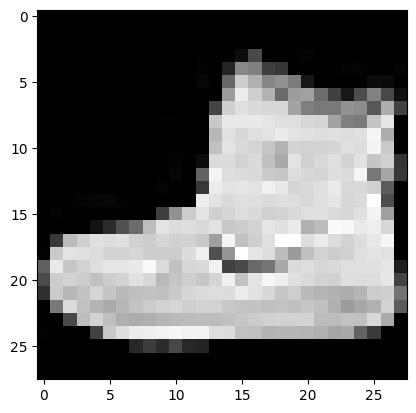

In [4]:
# Define a transform to normalize the data

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


def load_data(data_dir="./fmnist_data"):
    # Download the train and test data
    trainset = datasets.FashionMNIST(
        data_dir, download=True, train=True, transform=transform
    )
    valset = datasets.FashionMNIST(
        data_dir, download=True, train=False, transform=transform
    )

    return (
        trainset,
        valset,
    )


trainset, valset = load_data()

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True)

# Labels in the data and their corresponding integer mapping
label_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Report split sizes
print("Training set has {} instances".format(len(trainset)))
print("Validation set has {} instances".format(len(valset)))

# Plotting the image
plt.imshow(trainset[0][0][0], cmap="gray")

## Building the Model

In [114]:
class LenetCNN(nn.Module):
    def __init__(self):
        super(LenetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.relu1 =  nn.ReLU()
        self.avgpool1 = nn.AvgPool2d(2, stride=2)

        self.conv2 =  nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.relu2 =  nn.ReLU()
        self.avgpool2 = nn.AvgPool2d(2, stride=2)

        self.fc1 =  nn.Linear(in_features=400, out_features=120)
        self.relu3 =  nn.ReLU()
        self.fc2 =  nn.Linear(in_features=120, out_features=64)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.avgpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.avgpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        out = self.relu4(out)
        out = self.fc3(out)

        return out

In [111]:
# validating the model
def validate(model, data):
    total = 0
    correct = 0

    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct * 100 / total

In [119]:
# training function
def train(epochs=3, learning_rate=1e-3, device="cpu"):
    accuracies = []

    model = LenetCNN()
    cel = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    max_accuracy = 0

    for epoch in range(epochs):
        for i, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = model(images)
            loss = cel(pred, labels)
            loss.backward()
            optimizer.step()

        accuracy = float(validate(model, testloader))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(model)
            max_accuracy = accuracy
            print("Saving the best model with accuracy", accuracy)

        print("Epoch :", epoch + 1, "Accuracy :", accuracy, "%")
    plt.plot(accuracies)
    return best_model

Saving the best model with accuracy 80.12999725341797
Epoch : 1 Accuracy : 80.12999725341797 %
Saving the best model with accuracy 83.52999877929688
Epoch : 2 Accuracy : 83.52999877929688 %
Saving the best model with accuracy 85.16000366210938
Epoch : 3 Accuracy : 85.16000366210938 %
Saving the best model with accuracy 86.51000213623047
Epoch : 4 Accuracy : 86.51000213623047 %
Saving the best model with accuracy 86.94000244140625
Epoch : 5 Accuracy : 86.94000244140625 %
Saving the best model with accuracy 87.44999694824219
Epoch : 6 Accuracy : 87.44999694824219 %
Saving the best model with accuracy 88.37000274658203
Epoch : 7 Accuracy : 88.37000274658203 %
Saving the best model with accuracy 88.4800033569336
Epoch : 8 Accuracy : 88.4800033569336 %
Saving the best model with accuracy 88.52999877929688
Epoch : 9 Accuracy : 88.52999877929688 %
Saving the best model with accuracy 88.83000183105469
Epoch : 10 Accuracy : 88.83000183105469 %
Saving the best model with accuracy 89.540000915527

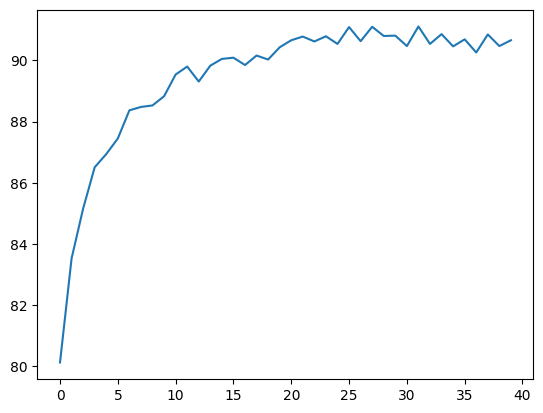

In [120]:
# training the model and saving the best model
timestamp = datetime.now()
lenet_model = train(epochs=40, learning_rate=0.001)
model_path = "./saved_models/best_model_{}".format(timestamp)
torch.save(lenet_model.state_dict(), model_path)

Model Test Accuracy : 0.9111
     0    1    2    3    4    5    6    7    8    9
0  845    1   13   15    2    3  113    0    8    0
1    1  984    0    6    1    0    6    0    2    0
2   16    0  865   10   52    0   51    0    6    0
3   13   11   14  911   19    0   24    0    8    0
4    2    0   49   29  841    0   76    0    3    0
5    0    0    0    1    0  983    0    9    0    7
6  100    1   64   16   41    0  764    0   14    0
7    0    0    0    0    0    8    0  978    0   14
8    4    0    1    2    0    0    1    5  987    0
9    0    0    1    0    0    5    0   41    0  953


<Axes: >

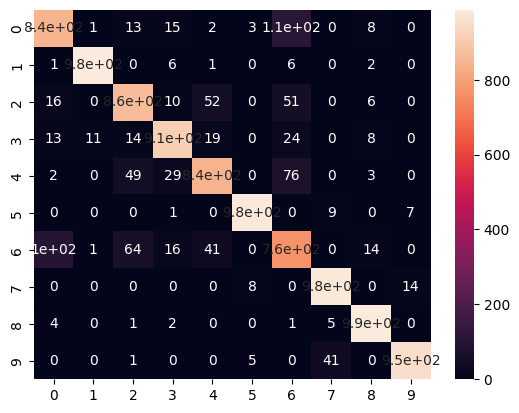

In [121]:
def predict_dataloader(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)


y_pred, y_true = predict_dataloader(lenet_model, testloader)
print("Model Test Accuracy :", accuracy_score(y_true=y_true, y_pred=y_pred))
conf_matrix = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred, labels=np.arange(0, 10))
)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True)

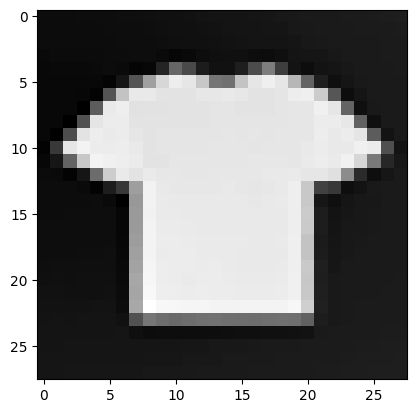

Predicted: T-shirt/Top, Probabiity: 68.47639679908752%


In [265]:
# Testing on out of sample dataset
path = "https://www.mrporter.com/variants/images/3633577411310824/in/w2000_q60.jpg"  # We can use any other image link here


def out_of_sample_image_transformer(path):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        image = Image.open(f).convert(mode="L")
        image = image.resize((28, 28))
        x = (255 - np.expand_dims(np.array(image), -1)) / 255.0
    return x


def out_of_sample_validation(image, model, device=device):
    with torch.no_grad():
        pred = model(torch.unsqueeze(transform(image), axis=1).float().to(device))
        return F.softmax(pred, dim=1).cpu().numpy()


# Displaying the image
def displaying_out_of_sample_image_from_path(path):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        image = Image.open(f).convert(mode="L")
        image = image.resize((28, 28))
        x = (255 - np.expand_dims(np.array(image), -1)) / 255.0
    plt.imshow(x.squeeze(-1), cmap="gray")
    plt.show()


displaying_out_of_sample_image_from_path(path)

# Predicting the out-of-sample image
transformed_image = out_of_sample_image_transformer(path)
out_of_sample_pred = out_of_sample_validation(
    transformed_image, lenet_model, device
)  # Add this to the out_of_sample function above #TODO
pred_id = np.argmax(out_of_sample_pred)
print(
    f"Predicted: {label_mapping[pred_id]}, Probabiity: {out_of_sample_pred[0][pred_id]*100}%"
)

In [266]:
#Hyperparameter tuning
#TODO

#### LIME 

torch.Size([1, 28, 28])


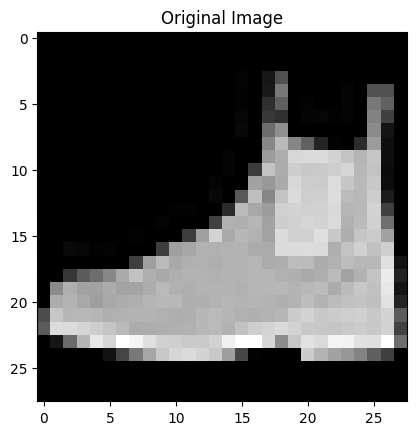

(1, 28, 28)


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


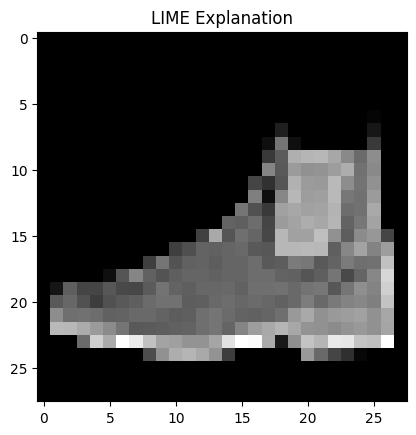

In [258]:
model = lenet_model
# Choose a sample image for explanation
samples, labels = next(iter(testloader))
image = samples[0]
label = int(labels[0].numpy())

plt.imshow(image.squeeze().numpy(), cmap="gray")
plt.title("Original Image")
plt.show()


def predict_fn(img):
    gray_images = rgb2gray(img).reshape(-1, 1, 28, 28)
    outputs = model(torch.from_numpy(gray_images).float())
    probabilities = F.softmax(outputs, dim=1)
    return probabilities.detach().numpy()


explainer = lime_image.LimeImageExplainer()

# Explain the prediction for the sample image
explanation = explainer.explain_instance(
    image.squeeze(0),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    batch_size=1,
    labels=labels,
)

# Display the LIME explanation
temp, mask = explanation.get_image_and_mask(
    label, positive_only=True, num_features=5, hide_rest=True
)
plt.imshow(mark_boundaries(temp, mask), cmap="gray")
plt.title("LIME Explanation")
plt.show()

torch.Size([1, 1, 28, 28])


  0%|          | 0/1000 [00:00<?, ?it/s]

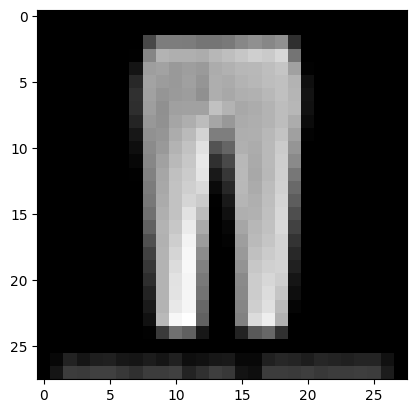

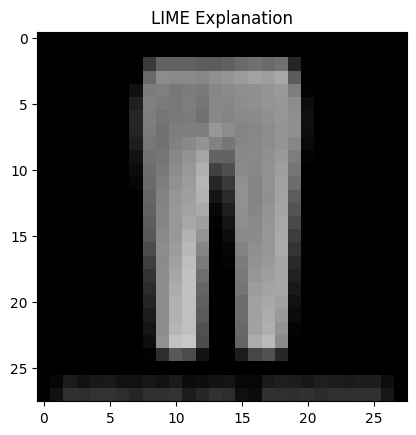

In [264]:
# Choose an out of sample image for explanation
path = "https://www.shutterstock.com/image-photo/light-grey-formal-mens-trousers-260nw-1096296503.jpg"
transformed_image = out_of_sample_image_transformer(path)
prediction = np.argmax(out_of_sample_validation(transformed_image, lenet_model, device))

transformed_image = transformed_image.transpose((2, 0, 1))
explanation = explainer.explain_instance(
    transformed_image.squeeze(0),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    batch_size=1,
    labels=labels,
)

# Display the LIME explanation
displaying_out_of_sample_image_from_path(path)
temp, mask = explanation.get_image_and_mask(
    prediction, positive_only=True, num_features=5, hide_rest=True
)
plt.imshow(mark_boundaries(temp, mask), cmap="gray")
plt.title("LIME Explanation")
plt.show()

#### SHAP

90 10


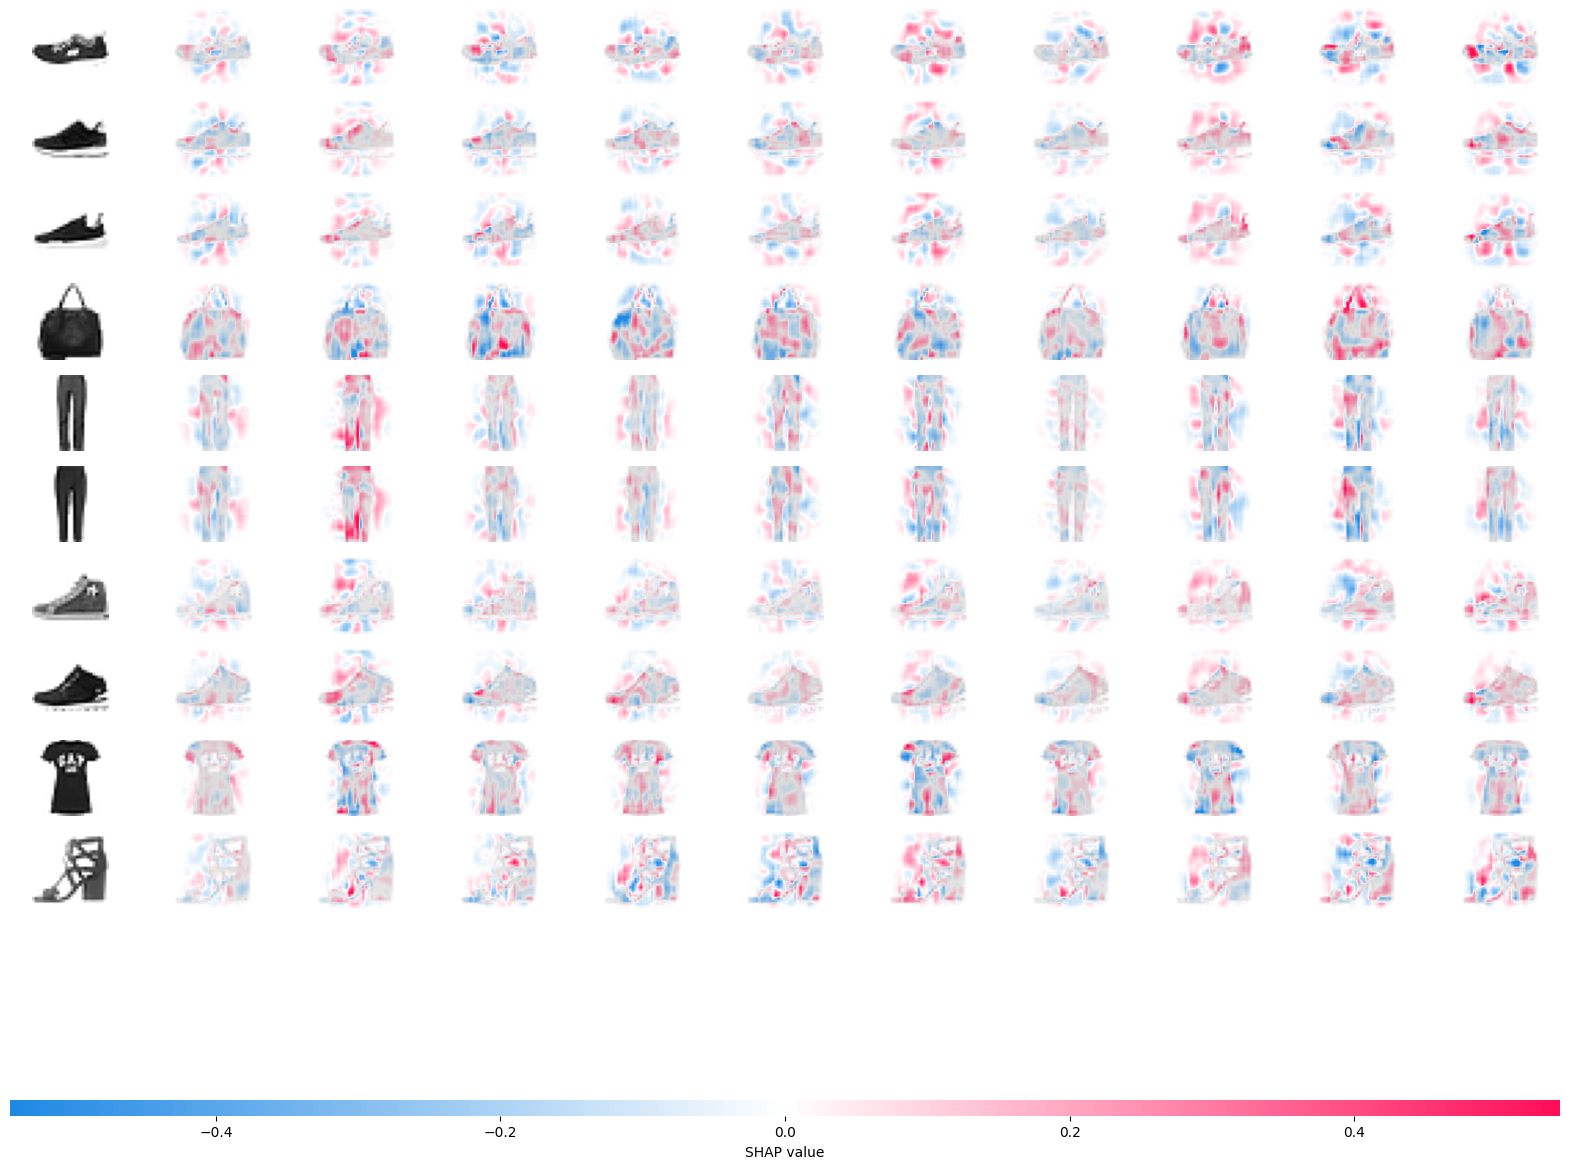

In [129]:
import shap

batch = next(iter(testloader))
img, _ = batch
img = img.view(-1, 1, 28, 28)

background = img[:90]
test_images = img[90:100]

print(len(background), len(test_images))

e = shap.DeepExplainer(model, img)
shap_values = e.shap_values(test_images)


shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

# Rough Work

In [82]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for img, labels in testloader:
        img, labels = img.to(device), labels.to(device)
        test = Variable(img)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(label_mapping[i], class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 90.80%
Accuracy of Trouser: 96.90%
Accuracy of Pullover: 86.70%
Accuracy of Dress: 89.90%
Accuracy of Coat: 93.80%
Accuracy of Sandal: 97.80%
Accuracy of Shirt: 55.60%
Accuracy of Sneaker: 98.50%
Accuracy of Bag: 98.10%
Accuracy of Ankle Boot: 92.90%
